In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pprint as pp

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

Let us first import the required data  (u.data) which contains the related ratings by different users on the different items: 

In [2]:
col_names = ['user id', 'item id', 'rating', 'timestamp']
df_ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=col_names)
df_ratings.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Now, let us have a look at the distribution of the ratings on the different items:

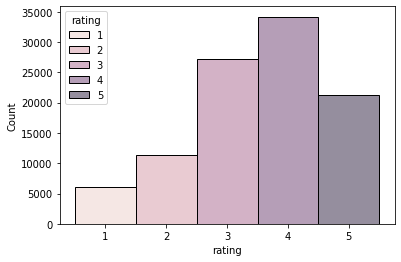

In [3]:
sns.histplot(data=df_ratings, x='rating', bins=[0.5,1.5,2.5,3.5,4.5,5.5], hue='rating')
plt.show()

The related data for different items are also provided in u.item. In what follows, we have imported the related data to be used later:

In [4]:
col_names_movies = '''movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'''

col_names_movies = col_names_movies.strip().split(' | ')
df_movies = pd.read_csv('./ml-100k/u.item', sep='|', encoding='latin-1', names=col_names_movies)
df_movies.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


The movies can be categorized in one of the following genres:

In [5]:
genres = '''unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'''.split(' | ')
pp.pprint(genres)

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']


Furthermore, we import u.user containing the related information of the users:

In [6]:
col_names_users = '''user id | age | gender | occupation | zip code'''
col_names_users = col_names_users.split(' | ')

df_users = pd.read_csv('./ml-100k/u.user', sep='|', names=col_names_users)
df_users.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Now, by merging the related data to users and the ratings, we can explore the relationship between the gender and rating, given as follows:


======= Mean rating based on Gender =======

        mean rating
gender             
F          3.531507
M          3.529289


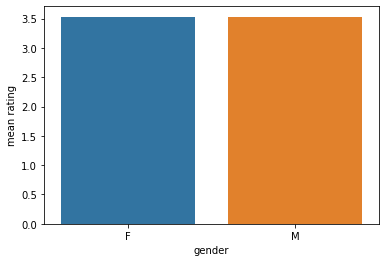

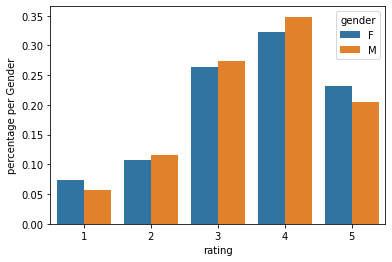

In [7]:
df_users_ratings = df_users.merge(df_ratings, on='user id')
gender_mean = df_users_ratings[['gender', 'rating']].groupby('gender').mean().rename(columns={'rating':'mean rating'}).reset_index()
sns.barplot(x='gender', y='mean rating', data=gender_mean)
print('\n======= Mean rating based on Gender =======\n')
print(gender_mean.set_index('gender'))
print('===========================================')
plt.show()

df_gender_rating = df_users_ratings[['gender', 'rating', 'item id']].groupby(['gender', 'rating']).count().reset_index().rename(columns={'item id':'frequency'})
df_gender_rating

gender_count = df_gender_rating[['gender','frequency']].groupby('gender').sum()
mask = df_gender_rating['gender']=='F'
df_gender_rating['percentage per Gender'] = np.where(mask,df_gender_rating['frequency']/gender_count.loc['F'].values, df_gender_rating['frequency']/gender_count.loc['M'].values)
sns.barplot(x='rating', y='percentage per Gender', hue='gender', data=df_gender_rating)
plt.show()

As one can see, the mean of the ratings is not different for male and female users. However, if we investigate the percentage of different ratings by different genders, we can see that the percentage of female who rate items as 1 and 5 is higher than that of men. In other words, women tend to rate items 1 and 5 more than men; on the other hand, men usually rate the filmes as 2, 3, and 4 more than women. This implies that "gender" could be an appropriate feature of the users for our recommender system. 

Now, let us investigate the impact of the age on the ratings. We have categorized the users in 6 different age intervals. The following heatmap shows the related data:

[ 6.934 18.    29.    40.    51.    62.    73.   ]


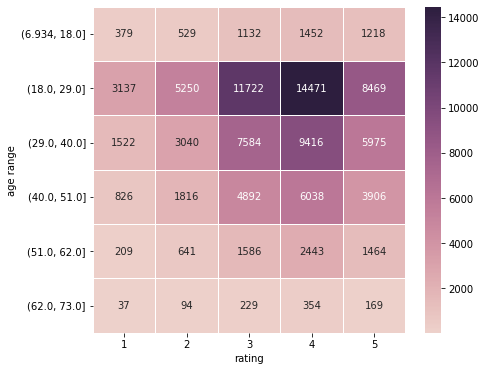

In [8]:
df_users_ratings['age range'], bins = pd.cut(df_users_ratings['age'], bins=6, retbins=True)
print(bins)
df_age_rating = df_users_ratings[['age range', 'rating', 'item id']].groupby(['age range', 'rating']).count().reset_index()
table = df_age_rating.pivot('age range', 'rating', 'item id')
plt.figure(figsize=(7,6))
sns.heatmap(table, cmap=sns.cubehelix_palette(as_cmap=True), linewidth=.5, annot=True, fmt='d')
plt.show()

We can use chisquare test to analyze the relationship between the categorical variables "rating" and "age range".

In [9]:
chi2, p, dof, expected = chi2_contingency(table)
print('The statistic value: {}'.format(chi2))
print('\nThe related p_value: {}'.format(p))
print('\nThe expected values:\n {}'.format(expected))

The statistic value: 557.2326874981123

The related p_value: 2.8705335196176394e-105

The expected values:
 [[  287.781     535.527    1278.5295   1609.5954    998.5671 ]
 [ 2630.2939   4894.6713  11685.65105 14711.56526  9126.81849]
 [ 1682.5107   3130.9569   7474.91865  9410.49438  5838.11937]
 [ 1067.9058   1987.2486   4744.4031   5972.93172  3705.51078]
 [  387.5573    721.1991   1721.80735  2167.65682  1344.77943]
 [   53.9513    100.3971    239.69035   301.75642   187.20483]]


Since the p-value is less than the assumed significance value (0.05), then we reject the NULL hypothesis mentioning that tere exists no association between the variables. Therefore, we accept the alternative hypothesis claiming there exist relationship between "age range" and "arting". Therefore, age should be considered as one of the features for the users in our recommender system.

Moreover, the mean of the ratings based on various users' occupation is depicted as follows: 

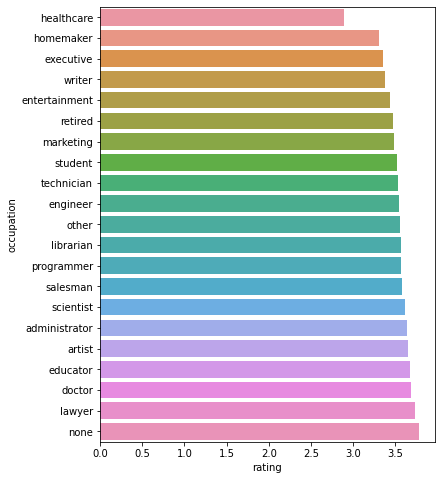

In [10]:
plt.figure(figsize=(6,8))
occupation_rating = df_users_ratings[['occupation', 'rating']].groupby('occupation').mean().sort_values(by='rating').reset_index()
sns.barplot(data=occupation_rating, y='occupation', x='rating')
plt.show()

## Feature Engineering for Users

As we mentioned earlier, the age, gender and occupation are appropriate features of the users for our recommender system. Additionally, we also consider the mean of ratings of various genre for each user, since it seems that they could be relevant features for our recommender system.  

In [11]:
df_ratings_users = df_ratings.merge(df_users, on='user id')
df = df_ratings_users.merge(df_movies, left_on='item id', right_on='movie id')
df[genres] = df[genres].multiply(df['rating'], axis='index')
df.head()

,user id,item id,rating,timestamp,age,gender,occupation,zip code,movie id,movie title,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0


In [12]:
users_rating_genres = ['user ' + genre + ' rating' for genre in genres]
rename_genres = {genre:user_rating_genre for genre, user_rating_genre in zip(genres, users_rating_genres)}

df_users_modified = df[['user id'] + genres].groupby('user id').sum().reset_index().rename(columns=rename_genres)
df_users_modified = df_users_modified.merge(df_users[['user id', 'age', 'occupation', 'gender']], on='user id')

df_users_modified[users_rating_genres] = df_users_modified[users_rating_genres].div(df_users_modified[users_rating_genres].sum(axis=1),                                                                                    axis=0)
df_users_modified

,user id,user unknown rating,user Action rating,user Adventure rating,user Animation rating,user Children's rating,user Comedy rating,user Crime rating,user Documentary rating,user Drama rating,...,user Musical rating,user Mystery rating,user Romance rating,user Sci-Fi rating,user Thriller rating,user War rating,user Western rating,age,occupation,gender
0,1,0.001925,0.120308,0.059192,0.019249,0.026468,0.152069,0.041386,0.011550,0.202117,...,0.018287,0.008662,0.083253,0.082772,0.090472,0.044273,0.010587,24,technician,M
1,2,0.000000,0.081545,0.027897,0.008584,0.025751,0.130901,0.072961,0.000000,0.287554,...,0.006438,0.030043,0.141631,0.032189,0.092275,0.023605,0.000000,53,other,F
2,3,0.000000,0.113043,0.040580,0.000000,0.000000,0.089855,0.086957,0.014493,0.185507,...,0.011594,0.101449,0.049275,0.063768,0.153623,0.040580,0.000000,23,writer,M
3,4,0.000000,0.133047,0.060086,0.000000,0.000000,0.085837,0.081545,0.021459,0.115880,...,0.021459,0.085837,0.055794,0.098712,0.184549,0.038627,0.000000,24,technician,M
4,5,0.003448,0.151724,0.092241,0.045690,0.061207,0.212069,0.030172,0.000000,0.062069,...,0.034483,0.007759,0.037931,0.100000,0.048276,0.038793,0.004310,33,other,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,0.000000,0.166287,0.079727,0.009112,0.009112,0.154897,0.029613,0.000000,0.186788,...,0.009112,0.009112,0.109339,0.075171,0.111617,0.034169,0.000000,26,student,F
939,940,0.000000,0.097052,0.044226,0.011057,0.025799,0.181818,0.036855,0.000000,0.212531,...,0.027027,0.015971,0.104423,0.071253,0.082310,0.060197,0.000000,32,administrator,M
940,941,0.000000,0.173516,0.123288,0.063927,0.041096,0.132420,0.013699,0.000000,0.095890,...,0.018265,0.022831,0.022831,0.141553,0.127854,0.022831,0.000000,20,student,M
941,942,0.000000,0.098535,0.069241,0.025300,0.074567,0.119840,0.000000,0.000000,0.182423,...,0.029294,0.047936,0.099867,0.033289,0.106525,0.062583,0.018642,48,librarian,F


Tp proceed further, we also need to convert the categorical variables 'gender' and 'occupation' to dummy/indicator variables.

In [13]:
df_users_modified = pd.get_dummies(df_users_modified, drop_first=True)
df_users_modified.head()

,user id,user unknown rating,user Action rating,user Adventure rating,user Animation rating,user Children's rating,user Comedy rating,user Crime rating,user Documentary rating,user Drama rating,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,gender_M
0,1,0.001925,0.120308,0.059192,0.019249,0.026468,0.152069,0.041386,0.011550,0.202117,...,0,0,0,0,0,0,0,1,0,1
1,2,0.000000,0.081545,0.027897,0.008584,0.025751,0.130901,0.072961,0.000000,0.287554,...,0,1,0,0,0,0,0,0,0,0
2,3,0.000000,0.113043,0.040580,0.000000,0.000000,0.089855,0.086957,0.014493,0.185507,...,0,0,0,0,0,0,0,0,1,1
3,4,0.000000,0.133047,0.060086,0.000000,0.000000,0.085837,0.081545,0.021459,0.115880,...,0,0,0,0,0,0,0,1,0,1
4,5,0.003448,0.151724,0.092241,0.045690,0.061207,0.212069,0.030172,0.000000,0.062069,...,0,1,0,0,0,0,0,0,0,0


## Feature Engineering for Items

One feature for the items that seems to be a relevant one for our recommender system could be the mean of the reatings for each item in our dataset. In what follows, we compute the mean of ratings for each item. "df" is a data frame obtianed by merging the related data of u.data, u.item and u.user which will be used for this purpose.

In [14]:
df.head()

,user id,item id,rating,timestamp,age,gender,occupation,zip code,movie id,movie title,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0


Let compute the mean of the ratings for each item as follows:

In [15]:
item_mean_rating = df[['item id',  'rating']].groupby(['item id']).mean().reset_index().rename(
                    columns={'rating':'mean rating'})
item_mean_rating.head()

,item id,mean rating
0,1,3.878319
1,2,3.206107
2,3,3.033333
3,4,3.550239
4,5,3.302326


In the following, the year of the release date is also extracted and used as one of the features for the items. Additionally, we will omit "movie title", "release date","IMDb URL", "Video release date" which seems that they won't be useful for our recommeneder system. 

In [16]:
df_movies['year'] = pd.DatetimeIndex(df_movies['release date']).year
df_movies_modified = df_movies.drop(columns=['movie title', 'release date', 'IMDb URL', 'video release date']).rename(
                                    columns={'movie id':'item id'})

df_movies_modified = df_movies_modified.merge(item_mean_rating, on='item id')
df_movies_modified.head()

,item id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,mean rating
0,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1995.0,3.878319
1,2,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1995.0,3.206107
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1995.0,3.033333
3,4,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1995.0,3.550239
4,5,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1995.0,3.302326


## Train and Test Data

Now, we merge the prepared date for users and items with the available data of ratings as follows:

In [17]:
df_total = df_ratings.merge(df_users_modified, on='user id').merge(df_movies_modified, on='item id')
df_total.head()

,user id,item id,rating,timestamp,user unknown rating,user Action rating,user Adventure rating,user Animation rating,user Children's rating,user Comedy rating,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,mean rating
0,196,242,3,881250949,0.0,0.020747,0.041494,0.000000,0.033195,0.473029,...,0,0,0,0,0,0,0,0,1997.0,3.991453
1,305,242,5,886307828,0.0,0.085993,0.053420,0.014984,0.012378,0.156352,...,0,0,0,0,0,0,0,0,1997.0,3.991453
2,6,242,4,883268170,0.0,0.057104,0.051666,0.023114,0.041468,0.157036,...,0,0,0,0,0,0,0,0,1997.0,3.991453
3,234,242,4,891033261,0.0,0.064305,0.051238,0.017882,0.048143,0.151307,...,0,0,0,0,0,0,0,0,1997.0,3.991453
4,63,242,3,875747190,0.0,0.077348,0.042357,0.023941,0.033149,0.186004,...,0,0,0,0,0,0,0,0,1997.0,3.991453


Let us have a look at the obtained data frame:

In [18]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 66 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user id                   100000 non-null  int64  
 1   item id                   100000 non-null  int64  
 2   rating                    100000 non-null  int64  
 3   timestamp                 100000 non-null  int64  
 4   user unknown rating       100000 non-null  float64
 5   user Action rating        100000 non-null  float64
 6   user Adventure rating     100000 non-null  float64
 7   user Animation rating     100000 non-null  float64
 8   user Children's rating    100000 non-null  float64
 9   user Comedy rating        100000 non-null  float64
 10  user Crime rating         100000 non-null  float64
 11  user Documentary rating   100000 non-null  float64
 12  user Drama rating         100000 non-null  float64
 13  user Fantasy rating       100000 non-null  fl

### Drop null values

There are quite a few number of missing values present in the year column. We can ignore those data without loss of too much information. 

In [19]:
df_total = df_total.dropna()
df_total.shape

(99991, 66)

In [20]:
out = df_total[['rating']].to_numpy()
print('The output for test and training: \n', out)
print('Shape of the output: {}'.format(out.shape))

The output for test and training: 
 [[3]
 [5]
 [4]
 ...
 [2]
 [3]
 [3]]
Shape of the output: (99991, 1)


In [21]:
user_columns = df_users_modified.columns
user_input = df_total[user_columns].drop(columns=['user id']).to_numpy()
print('The user input for test and training: \n', user_input)
print('\nShape of the user input: {}'.format(user_input.shape))


The user input for test and training: 
 [[0.         0.02074689 0.04149378 ... 0.         1.         1.        ]
 [0.         0.08599349 0.0534202  ... 0.         0.         1.        ]
 [0.         0.05710401 0.05166553 ... 0.         0.         1.        ]
 ...
 [0.         0.08295626 0.02413273 ... 0.         0.         1.        ]
 [0.         0.1394958  0.06764706 ... 0.         1.         1.        ]
 [0.         0.11934156 0.06447188 ... 0.         0.         1.        ]]

Shape of the user input: (99991, 41)


In [22]:
item_columns = df_movies_modified.columns
item_input = df_total[item_columns].drop(columns='item id').to_numpy()
print('The item input for test and training: \n', item_input)
print('\nShape of the item input: {}'.format(item_input.shape))

The item input for test and training: 
 [[   0.            0.            0.         ...    0.
  1997.            3.99145299]
 [   0.            0.            0.         ...    0.
  1997.            3.99145299]
 [   0.            0.            0.         ...    0.
  1997.            3.99145299]
 ...
 [   0.            0.            0.         ...    0.
  1998.            2.        ]
 [   0.            0.            0.         ...    0.
  1994.            3.        ]
 [   0.            0.            0.         ...    0.
  1996.            3.        ]]

Shape of the item input: (99991, 21)


### Split data into train and test

Now, we split the data into the train and test data as follows:

In [23]:
item_train, item_test = train_test_split(item_input, train_size=0.9, 
                                          shuffle=True, random_state=1979)

user_train, user_test = train_test_split(user_input, train_size=0.9, 
                                          shuffle=True, random_state=1979)

out_train, out_test = train_test_split(out, train_size=0.9, shuffle=True,
                                      random_state=1979)

print("************* Test Data ******************")
print("The size of item_train: ", item_train.shape)
print("The size of user_train: ", user_train.shape)
print("The size of out_train: ", out_train.shape)
print("\n************* Test Data ******************")
print("The size of item_test: ", item_test.shape)
print("The size of user_test: ", user_test.shape)
print("The size of out_test: ", out_test.shape)

************* Test Data ******************
The size of item_train:  (89991, 21)
The size of user_train:  (89991, 41)
The size of out_train:  (89991, 1)

************* Test Data ******************
The size of item_test:  (10000, 21)
The size of user_test:  (10000, 41)
The size of out_test:  (10000, 1)


### Scale Train and Test Data

Using MaxAbsScaler() from Scikit-learn, we scale the input data to speed up the training of the Neural Network used for our recommender system.

In [24]:
itemScaler = MaxAbsScaler()
item_train_scaled = itemScaler.fit_transform(item_train)
item_test_scaled = itemScaler.transform(item_test)

userScaler = MaxAbsScaler()
user_train_scaled = userScaler.fit_transform(user_train)
user_test_scaled = userScaler.transform(user_test)

outScaler = MaxAbsScaler()
out_train_scaled = outScaler.fit_transform(out_train)
out_test_scaled = outScaler.transform(out_test)

## Neural Network

The recommender system comprises two neural Network (NN). The input to the first NN, user_NN, are the users' features and the output is a vector with num_feature = 16 elements.

The input to the second NN are the item's features and the output is a vector with again num_feature = 32 elements. The dot product of the output of the user_NN and item_NN results the output of the recommneder system. 

In what follows, we define the both NNs.

In [25]:
num_feature = 16

tf.random.set_seed(1979)
tf.keras.backend.clear_session()

user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=num_feature, activation='linear')
], name = 'User_NN')

item_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=num_feature, activation='linear'),
], name = 'Item_NN')

user_inp = tf.keras.layers.Input(shape=user_input.shape[1], name="User's features")
item_inp = tf.keras.layers.Input(shape=item_input.shape[1], name="Item's features")

user_nn_out = user_NN(user_inp)
item_nn_out = item_NN(item_inp)

output = tf.keras.layers.Dot(axes=1)([user_nn_out, item_nn_out])

model = tf.keras.models.Model(inputs=[user_inp, item_inp], outputs=output)
model.summary()

Metal device set to: Apple M1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User's features (InputLayer)   [(None, 41)]         0           []                               
                                                                                                  
 Item's features (InputLayer)   [(None, 21)]         0           []                               
                                                                                                  
 User_NN (Sequential)           (None, 16)           45712       ["User's features[0][0]"]        
                                                                                                  
 Item_NN (Sequential)           (None, 16)           40592       ["Item's features[0][0]"]        
                                                                

2023-03-09 13:28:01.293033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-09 13:28:01.293159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


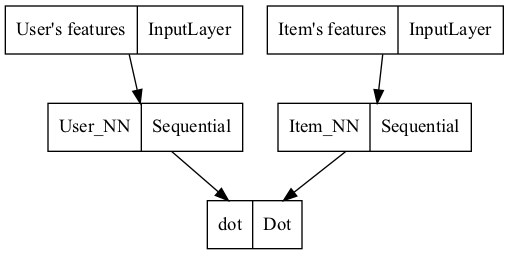

In [26]:
tf.keras.utils.plot_model(model)

To train the recommneder system, we employ the Adam optimizer and mean square error (MSE) as the loss function. 

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

Now, we are able to train the model:

In [28]:
best_model_callback = tf.keras.callbacks.ModelCheckpoint('recommender_model.h5', monitor='val_mae', 
                                                         save_best_only=True, verbose=1)


history = model.fit(x=[user_train_scaled, item_train_scaled], y=out_train_scaled, epochs=300,
                    validation_split=0.1, batch_size=1024, use_multiprocessing=True,
                    callbacks=[best_model_callback])

Epoch 1/300


2023-03-09 13:28:02.542592: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/80 [..............................] - ETA: 35s - loss: 0.4906 - mae: 0.6630

2023-03-09 13:28:02.829198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - ETA: 0s - loss: 0.2885 - mae: 0.3223
Epoch 1: val_mae improved from inf to 0.17765, saving model to recommender_model.h5
80/80 [==============================] - 1s 10ms/step - loss: 0.2885 - mae: 0.3223 - val_loss: 0.0467 - val_mae: 0.1776
Epoch 2/300
 8/80 [==>...........................] - ETA: 0s - loss: 0.0463 - mae: 0.1748

2023-03-09 13:28:03.653291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - ETA: 0s - loss: 0.0439 - mae: 0.1702
Epoch 2: val_mae improved from 0.17765 to 0.16754, saving model to recommender_model.h5
80/80 [==============================] - 1s 7ms/step - loss: 0.0439 - mae: 0.1702 - val_loss: 0.0432 - val_mae: 0.1675
Epoch 3/300
80/80 [==============================] - ETA: 0s - loss: 0.0410 - mae: 0.1634
Epoch 3: val_mae improved from 0.16754 to 0.16199, saving model to recommender_model.h5
80/80 [==============================] - 1s 8ms/step - loss: 0.0410 - mae: 0.1634 - val_loss: 0.0405 - val_mae: 0.1620
Epoch 4/300
79/80 [============================>.] - ETA: 0s - loss: 0.0393 - mae: 0.1588
Epoch 4: val_mae improved from 0.16199 to 0.15875, saving model to recommender_model.h5
80/80 [==============================] - 1s 8ms/step - loss: 0.0393 - mae: 0.1588 - val_loss: 0.0392 - val_mae: 0.1588
Epoch 5/300
73/80 [==========================>...] - ETA: 0s - loss: 0.0389 - mae: 0.1578
Epoch 5: val_mae improved from 

80/80 [==============================] - 1s 7ms/step - loss: 0.0356 - mae: 0.1499 - val_loss: 0.0390 - val_mae: 0.1603
Epoch 32/300
73/80 [==========================>...] - ETA: 0s - loss: 0.0351 - mae: 0.1489
Epoch 32: val_mae did not improve from 0.15144
80/80 [==============================] - 1s 7ms/step - loss: 0.0351 - mae: 0.1489 - val_loss: 0.0363 - val_mae: 0.1526
Epoch 33/300
76/80 [===========================>..] - ETA: 0s - loss: 0.0349 - mae: 0.1483
Epoch 33: val_mae improved from 0.15144 to 0.15113, saving model to recommender_model.h5
80/80 [==============================] - 1s 7ms/step - loss: 0.0349 - mae: 0.1483 - val_loss: 0.0372 - val_mae: 0.1511
Epoch 34/300
74/80 [==========================>...] - ETA: 0s - loss: 0.0355 - mae: 0.1497
Epoch 34: val_mae improved from 0.15113 to 0.15011, saving model to recommender_model.h5
80/80 [==============================] - 1s 7ms/step - loss: 0.0354 - mae: 0.1496 - val_loss: 0.0360 - val_mae: 0.1501
Epoch 35/300
73/80 [======

Epoch 63/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0335 - mae: 0.1451
Epoch 63: val_mae did not improve from 0.14825
80/80 [==============================] - 1s 7ms/step - loss: 0.0335 - mae: 0.1452 - val_loss: 0.0364 - val_mae: 0.1489
Epoch 64/300
79/80 [============================>.] - ETA: 0s - loss: 0.0337 - mae: 0.1456
Epoch 64: val_mae did not improve from 0.14825
80/80 [==============================] - 1s 7ms/step - loss: 0.0337 - mae: 0.1456 - val_loss: 0.0390 - val_mae: 0.1524
Epoch 65/300
75/80 [===========================>..] - ETA: 0s - loss: 0.0336 - mae: 0.1453
Epoch 65: val_mae improved from 0.14825 to 0.14788, saving model to recommender_model.h5
80/80 [==============================] - 1s 7ms/step - loss: 0.0335 - mae: 0.1450 - val_loss: 0.0358 - val_mae: 0.1479
Epoch 66/300
80/80 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.1446
Epoch 66: val_mae improved from 0.14788 to 0.14737, saving model to recommender_model.h5
80/80 [

Epoch 94/300
80/80 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.1428
Epoch 94: val_mae did not improve from 0.14575
80/80 [==============================] - 1s 7ms/step - loss: 0.0326 - mae: 0.1428 - val_loss: 0.0345 - val_mae: 0.1480
Epoch 95/300
79/80 [============================>.] - ETA: 0s - loss: 0.0326 - mae: 0.1428
Epoch 95: val_mae did not improve from 0.14575
80/80 [==============================] - 1s 7ms/step - loss: 0.0326 - mae: 0.1428 - val_loss: 0.0366 - val_mae: 0.1481
Epoch 96/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0325 - mae: 0.1425
Epoch 96: val_mae did not improve from 0.14575
80/80 [==============================] - 1s 7ms/step - loss: 0.0324 - mae: 0.1423 - val_loss: 0.0355 - val_mae: 0.1465
Epoch 97/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0328 - mae: 0.1433
Epoch 97: val_mae did not improve from 0.14575
80/80 [==============================] - 1s 7ms/step - loss: 0.0327 - mae: 0.1431 - val_los

79/80 [============================>.] - ETA: 0s - loss: 0.0321 - mae: 0.1414
Epoch 125: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0320 - mae: 0.1414 - val_loss: 0.0341 - val_mae: 0.1459
Epoch 126/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0318 - mae: 0.1409
Epoch 126: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0319 - mae: 0.1411 - val_loss: 0.0356 - val_mae: 0.1507
Epoch 127/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0325 - mae: 0.1427
Epoch 127: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0325 - mae: 0.1427 - val_loss: 0.0345 - val_mae: 0.1473
Epoch 128/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0319 - mae: 0.1410
Epoch 128: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0319 - mae: 0.1410 - val_loss: 0.0

Epoch 157/300
80/80 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.1400
Epoch 157: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0315 - mae: 0.1400 - val_loss: 0.0343 - val_mae: 0.1455
Epoch 158/300
79/80 [============================>.] - ETA: 0s - loss: 0.0314 - mae: 0.1399
Epoch 158: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0314 - mae: 0.1399 - val_loss: 0.0343 - val_mae: 0.1454
Epoch 159/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0313 - mae: 0.1397
Epoch 159: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0313 - mae: 0.1397 - val_loss: 0.0345 - val_mae: 0.1474
Epoch 160/300
80/80 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.1406
Epoch 160: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0316 - mae: 0.1406 -

Epoch 189/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0313 - mae: 0.1398
Epoch 189: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0314 - mae: 0.1400 - val_loss: 0.0346 - val_mae: 0.1449
Epoch 190/300
80/80 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.1398
Epoch 190: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0314 - mae: 0.1398 - val_loss: 0.0348 - val_mae: 0.1456
Epoch 191/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0311 - mae: 0.1391
Epoch 191: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0312 - mae: 0.1393 - val_loss: 0.0342 - val_mae: 0.1466
Epoch 192/300
73/80 [==========================>...] - ETA: 0s - loss: 0.0310 - mae: 0.1389
Epoch 192: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0311 - mae: 0.1392 -

Epoch 221/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0310 - mae: 0.1387
Epoch 221: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0310 - mae: 0.1389 - val_loss: 0.0347 - val_mae: 0.1474
Epoch 222/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0309 - mae: 0.1386
Epoch 222: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0310 - mae: 0.1387 - val_loss: 0.0345 - val_mae: 0.1457
Epoch 223/300
79/80 [============================>.] - ETA: 0s - loss: 0.0310 - mae: 0.1388
Epoch 223: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0310 - mae: 0.1388 - val_loss: 0.0343 - val_mae: 0.1466
Epoch 224/300
77/80 [===========================>..] - ETA: 0s - loss: 0.0313 - mae: 0.1397
Epoch 224: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0313 - mae: 0.1397 -

Epoch 253/300
80/80 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.1388
Epoch 253: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0310 - mae: 0.1388 - val_loss: 0.0346 - val_mae: 0.1475
Epoch 254/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0310 - mae: 0.1388
Epoch 254: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0310 - mae: 0.1387 - val_loss: 0.0342 - val_mae: 0.1455
Epoch 255/300
78/80 [============================>.] - ETA: 0s - loss: 0.0309 - mae: 0.1386
Epoch 255: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0309 - mae: 0.1386 - val_loss: 0.0347 - val_mae: 0.1451
Epoch 256/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0308 - mae: 0.1386
Epoch 256: val_mae did not improve from 0.14418
80/80 [==============================] - 1s 7ms/step - loss: 0.0309 - mae: 0.1386 -

80/80 [==============================] - 1s 7ms/step - loss: 0.0309 - mae: 0.1385 - val_loss: 0.0339 - val_mae: 0.1444
Epoch 285/300
79/80 [============================>.] - ETA: 0s - loss: 0.0308 - mae: 0.1384
Epoch 285: val_mae did not improve from 0.14403
80/80 [==============================] - 1s 7ms/step - loss: 0.0308 - mae: 0.1384 - val_loss: 0.0343 - val_mae: 0.1457
Epoch 286/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0308 - mae: 0.1385
Epoch 286: val_mae did not improve from 0.14403
80/80 [==============================] - 1s 7ms/step - loss: 0.0309 - mae: 0.1386 - val_loss: 0.0352 - val_mae: 0.1452
Epoch 287/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0311 - mae: 0.1390
Epoch 287: val_mae did not improve from 0.14403
80/80 [==============================] - 1s 7ms/step - loss: 0.0311 - mae: 0.1390 - val_loss: 0.0338 - val_mae: 0.1447
Epoch 288/300
72/80 [==========================>...] - ETA: 0s - loss: 0.0308 - mae: 0.1385
Epoch 288: v

Now, we can plot the training and validation trajectories as follows:

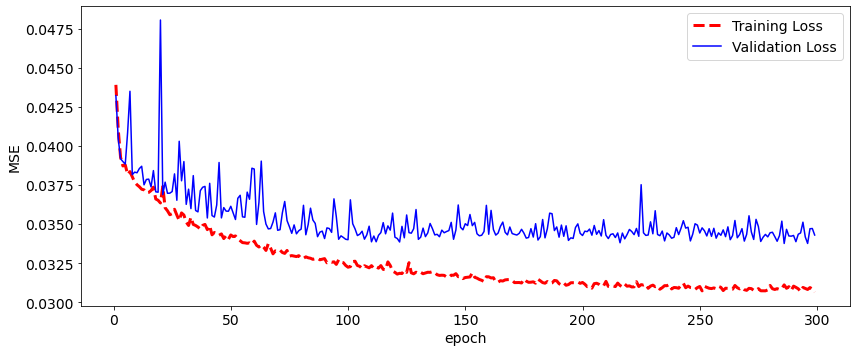

In [29]:
fig, axs = plt.subplots(1,1, figsize=(12,5))
axs.plot(history.epoch[1:], history.history['loss'][1:], 'r--', linewidth=3,  label='Training Loss')
axs.plot(history.epoch[1:], history.history['val_loss'][1:], 'b', label='Validation Loss')
axs.legend(fontsize=14)

axs.set_ylabel('MSE', fontsize=14)
axs.set_xlabel('epoch', fontsize=14)
axs.xaxis.set_tick_params(labelsize=14)
axs.yaxis.set_tick_params(labelsize=14)
plt.tight_layout()
plt.show()

The training loss is increasing showing that the model is learning using the provided data. Furthermore, the difference between the training and validation is not too much showing that the model has not overfitted the training data. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


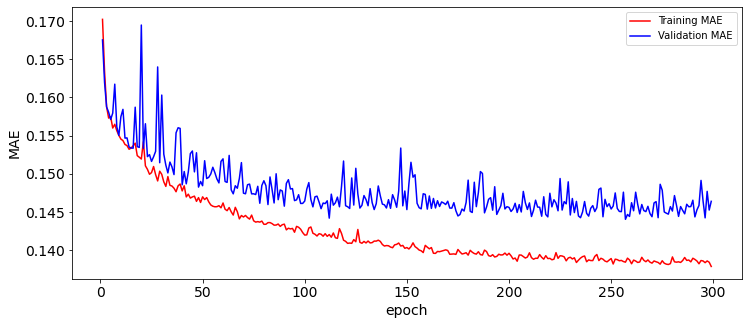

In [30]:
fig, axs = plt.subplots(1,1, figsize=(12,5))

axs.plot(history.epoch[1:], history.history['mae'][1:], 'r', label='Training MAE')
axs.plot(history.epoch[1:], history.history['val_mae'][1:], 'b', label='Validation MAE')
axs.legend()

axs.set_ylabel('MAE', fontsize=14)
axs.set_xlabel('epoch', fontsize=14)
axs.xaxis.set_tick_params(labelsize=14)
axs.yaxis.set_tick_params(labelsize=14)
plt.savefig('MAE-LPV.eps')
plt.show()

In [31]:
model.load_weights('recommender_model.h5')
model.evaluate(x=[user_test_scaled, item_test_scaled], y=out_test_scaled)

313/313 [==============================] - 1s 4ms/step - loss: 0.0343 - mae: 0.1440


[0.034286726266145706, 0.14401420950889587]

It is comparable to the training loss indicating the model has not substantially overfitted the training data.

## Predictions for a User

Let's look at the predictions for one of the users in our dataset and compare the output of the recommender model with his/her ratings.

In [32]:
df_users.columns

Index(['user id', 'age', 'gender', 'occupation', 'zip code'], dtype='object')

In [33]:
df_users.nunique(axis=0)

user id       943
age            61
gender          2
occupation     21
zip code      795
dtype: int64

We have 943 users in our dataset. Let's randomly choose one of them:

In [34]:
np.random.seed(58)
user_random = np.random.randint(1, 944)
user_random

804

In [35]:
user_random_feature = df_users_modified[df_users_modified['user id']==user_random]
user_random_feature

,user id,user unknown rating,user Action rating,user Adventure rating,user Animation rating,user Children's rating,user Comedy rating,user Crime rating,user Documentary rating,user Drama rating,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,gender_M
803,804,0.0,0.144399,0.08783,0.01898,0.04131,0.136211,0.031262,0.002233,0.134351,...,0,0,0,0,0,0,0,0,0,1


In [36]:
# number of ratings
num_ratings = df_ratings[df_ratings['user id']==user_random]['rating'].count()
print(f'The number of ratings made by this particular user: {num_ratings}')

# construct input to the user_NN
user_feat = user_random_feature.drop(columns='user id').to_numpy()
user_input = user_feat.repeat(num_ratings, axis=0)
user_input_scaled = userScaler.transform(user_input)

# construct input to item_NN
rated_items = df_ratings[df_ratings['user id']==user_random]['item id'].values
item_input = df_movies_modified[df_movies_modified['item id'].isin(rated_items)].drop(columns='item id').to_numpy()
item_input_scaled = itemScaler.transform(item_input)

user_ratings = df_ratings[df_ratings['user id']==user_random]['rating'].values

The number of ratings made by this particular user: 332


In [37]:
results = df_ratings[df_ratings['user id']==user_random].copy()

model_out = outScaler.inverse_transform(
    model.predict([user_input_scaled, item_input_scaled]))

11/11 [==============================] - 0s 4ms/step


2023-03-09 13:30:47.331324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [38]:
results['Predicted rating'] = model_out.squeeze().tolist()

In [39]:
results = results.drop(columns='timestamp')
results

,user id,item id,rating,Predicted rating
52936,804,11,4,3.899116
53132,804,546,3,3.784192
53138,804,31,4,3.862197
53349,804,204,4,4.244761
53411,804,82,5,4.146472
...,...,...,...,...
99448,804,435,3,3.077899
99508,804,294,5,3.782798
99545,804,132,4,3.149156
99564,804,1060,3,3.079911


Lets's also evaluate the model using the data for this specific user as follows:

In [40]:
output_scaled = outScaler.transform(user_ratings.reshape(-1,1))
model.evaluate(x=[user_input_scaled, item_input_scaled], y=output_scaled)

11/11 [==============================] - 0s 5ms/step - loss: 0.0357 - mae: 0.1483


[0.03565368056297302, 0.14834906160831451]

Intrestingly, the obtained values for MSA and MAE are approximately the same values obtained for the test set.

## Finding Similar Items

The output of the neural network item_NN is a vector with 32 elements. The simialr items have similar related vectors. One can use the item_NN to find similar items. 

One may use a similarity measure as the squared distance between the two vectors.

In [41]:
def squared_dist(a, b):
    '''This function returns the distance between two vectors a and b'''
    
    return np.sum(np.square(a - b))

In [42]:
chosen_item = 100
df_movies[df_movies['movie id']==chosen_item].set_index('movie id').T

movie id,100
movie title,Fargo (1996)
release date,14-Feb-1997
video release date,NaN
IMDb URL,http://us.imdb.com/M/title-exact?Fargo%20(1996)
unknown,0
Action,0
Adventure,0
Animation,0
Children's,0
Comedy,0


In [43]:
similar_movies = {}
for id in df_movies['movie id']:
    a = df_movies_modified[df_movies_modified['item id']==id].drop(columns='item id').to_numpy()
    b = df_movies_modified[df_movies_modified['item id']==chosen_item].drop(columns='item id').to_numpy()
    if id != chosen_item:
        similar_movies[id] = squared_dist(a, b)

In [44]:
# Let's choose the three most similar movies 
num_similar_movies = 3

sorted_results = dict(sorted(similar_movies.items(), key=lambda item: item[1])[:num_similar_movies])
sorted_results

{332: 0.4815990097956528, 1143: 1.0241839233678467, 754: 1.592202429364847}

In [45]:
df_movies[df_movies['movie id'].isin(sorted_results.keys())].set_index('movie id').T

movie id,332,754,1143
movie title,Kiss the Girls (1997),Red Corner (1997),Hard Eight (1996)
release date,01-Jan-1997,01-Jan-1997,28-Feb-1997
video release date,NaN,NaN,NaN
IMDb URL,http://us.imdb.com/M/title-exact?Kiss+the+Girl...,http://us.imdb.com/M/title-exact?Red+Corner+(1...,http://us.imdb.com/Title?Hard+Eight+(1996)
unknown,0,0,0
Action,0,0,0
Adventure,0,0,0
Animation,0,0,0
Children's,0,0,0
Comedy,0,0,0
